# Importation des modules

In [2]:
# Pour manipuler et visualiser les données
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Pour séparer et évaluer les données
from sklearn.model_selection import train_test_split, cross_validate, KFold, learning_curve, GridSearchCV, RandomizedSearchCV

# Pour préparer les données
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline

# Pour créer des arbres de classification
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier

# Pour faire un modèle de régression logistique 
from sklearn.linear_model import LogisticRegression

# Pour utiliser xgboost
import xgboost as xgb

# Pour utiliser les métriques
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report

# Pour exporter notre modèle
import pickle

# Création du dataset et Dummy Classifier

On commence par créer un dataset avec les variables :
<p style='color: #FFA07A'> NAICS, NoEmp, RetainedJob, UrbanRural, Term, UrbanRural, MIS_Status </p>

In [3]:
df = pd.read_csv("archive/SBAnational_clean.csv")

/tmp/ipykernel_46372/3668100114.py:1: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("archive/SBAnational_clean.csv")


In [4]:
df['NAICS'] = df['NAICS'].astype(str).apply(lambda x : x[:2])
df[['NAICS']] = df[['NAICS']].astype(int)

In [5]:
df["NAICS"].unique()

array([45, 72, 62,  0, 33, 81, 23, 44, 42, 61, 53, 54, 31, 51, 71, 52, 21,
       32, 56, 48, 11, 92, 22, 49, 55])

In [6]:
# Dataframe contenant les variables explicatives
X = df[['NAICS', 'NoEmp',  'RetainedJob', 'UrbanRural','Term']]

# On transforme les valeurs de MIS_Status en 0 ou 1
y = df['MIS_Status'].astype('category').cat.codes

In [7]:
y.value_counts()

1    729148
0    155977
dtype: int64

On crée maintenant notre jeu de données d'entraînement et de test :

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.2, random_state=42, stratify=y)

On sépare les variables numériques et catégorielle :

In [9]:
var_num = ['NoEmp','RetainedJob','Term','NAICS']

var_cat = [ 'UrbanRural']

Puis on crée un transformateur de colonne :

In [10]:
preprocessor = make_column_transformer(
    (StandardScaler(), var_num),
    (OneHotEncoder(), var_cat)
)

On commence notre modélisation par un Dummy Classifier qui servira de point de comparaison :

In [11]:
dummy = make_pipeline(preprocessor, DummyClassifier())

dummy.fit(X_train, y_train)

y_pred = dummy.predict(X_test)

dummy_report = (classification_report(y_test, y_pred))
print(dummy_report)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00     31195
           1       0.82      1.00      0.90    145830

    accuracy                           0.82    177025
   macro avg       0.41      0.50      0.45    177025
weighted avg       0.68      0.82      0.74    177025



/home/apprenant/miniconda3/envs/potages/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/apprenant/miniconda3/envs/potages/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/apprenant/miniconda3/envs/potages/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

# Random Forest Classifier

Nous allons maintenant utiliser un Random Forest Classififier sans paramètres pour le comparer avec notre Dummy Classifier :

In [12]:
# # Entraînement du modèle
# rf_pipe = make_pipeline(preprocessor, RandomForestClassifier())
# rf_pipe.fit(X_train, y_train)

On affiche l'importance des features :

In [13]:
# importances = rf_pipe[-1].feature_importances_
# importances
# # features = pd.DataFrame({"feature": X_train.columns, "importance": importances})
# # features

In [14]:
# rf_pipe.get_feature_names_out

In [15]:
# y_pred = rf_pipe.predict(X_test)

# rfc_report = classification_report(y_test, y_pred)
# print(rfc_report)

En utilisant un Random Forest Classifier sans paramètres, on obtient de bons résultats, proches de notre Dummy Classifier pour les classes positives. <br>
On va essayer d'affiner notre modèle avec en cherchant les meilleurs hyperparamètres :

In [16]:
# # On définit les paramètres à rechercher avec un intervalle de recherche
# param_dist = {'n_estimators': np.arange(30, 100, 1), 
#               'max_depth': np.arange(1, 11),
#               'min_samples_split': np.arange(2, 10),
#               'min_samples_leaf': np.arange(1, 10),
#               'criterion': ['gini','entropy']}

# # On crée un objet Random Search 
# random_search = RandomizedSearchCV(rf_pipe[-1], param_distributions=param_dist,
#                                   cv=5, n_jobs=-1, verbose=1)

# # On entrâine le modèle
# random_search.fit(X_train, y_train)

# # On récupère les meilleurs hyperparamètres trouvés
# best_params = random_search.best_params_
# print(best_params)

# # Entraînement du modèle
# rf_pipe = make_pipeline(preprocessor, RandomForestClassifier(**best_params, class_weight="balanced"))
# rf_pipe.fit(X_train, y_train)

# y_pred = rf_pipe.predict(X_test)

# print(f"resultats après grid search :\n {classification_report(y_test, y_pred)}")
# print(f"resultats avant grid search :\n {rfc_report}")

# Régression logistique

In [17]:
# # Entraînement du modèle
# rf_pipe_log = make_pipeline(preprocessor, LogisticRegression())
# rf_pipe_log.fit(X_train, y_train)

In [18]:
# y_pred = rf_pipe_log.predict(X_test)

# log_report = classification_report(y_test, y_pred)
# print(log_report)

In [19]:
# # #On définit les paramètres à rechercher avec un intervalle de recherche
# param_dist = {'C': np.logspace(-4, 4, 20),
#               'penalty': ['l1', 'l2', 'elasticnet'],
#               'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}

# # On crée un objet Random Search 
# random_search = RandomizedSearchCV(rf_pipe_log[-1], param_distributions=param_dist,
#                                    n_iter=50, cv=5, n_jobs=-1, verbose=1)

# # On entrâine le modèle
# random_search.fit(X_train, y_train) 

# # On récupère les meilleurs hyperparamètres trouvés
# best_params = random_search.best_params_
# print(best_params)

# # Entraînement du modèle
# rf_pipe_log_opti = make_pipeline(preprocessor, LogisticRegression(**best_params, class_weight="balanced"))
# rf_pipe_log_opti.fit(X_train, y_train)

# y_pred = rf_pipe_log_opti.predict(X_test)

In [20]:
# print(f"resultats après grid search :\n {classification_report(y_test, y_pred)}")
# print(f"resultats avant grid search :\n {log_report}")

# XGBoost

In [21]:
# Entraînement du modèle
xgb_pipe = make_pipeline(preprocessor, xgb.XGBClassifier(class_weight="balanced"))
xgb_pipe.fit(X_train, y_train)

[10:02:25] WARNING: ../src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['NoEmp', 'RetainedJob',
                                                   'Term', 'NAICS']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(),
                                                  ['UrbanRural'])])),
                ('xgbclassifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               class_weight='balanced', colsample_bylevel=None,
                               colsample_bynode=None, colsample_...
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, ...))])

In [22]:
y_pred = xgb_pipe.predict(X_test)

xgb_report = classification_report(y_test, y_pred)
print(xgb_report)

              precision    recall  f1-score   support

           0       0.82      0.78      0.80     31195
           1       0.95      0.96      0.96    145830

    accuracy                           0.93    177025
   macro avg       0.89      0.87      0.88    177025
weighted avg       0.93      0.93      0.93    177025



In [23]:
xgb_pipe.get_params()

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(transformers=[('standardscaler', StandardScaler(),
                                    ['NoEmp', 'RetainedJob', 'Term', 'NAICS']),
                                   ('onehotencoder', OneHotEncoder(),
                                    ['UrbanRural'])])),
  ('xgbclassifier',
   XGBClassifier(base_score=None, booster=None, callbacks=None,
                 class_weight='balanced', colsample_bylevel=None,
                 colsample_bynode=None, colsample_bytree=None,
                 early_stopping_rounds=None, enable_categorical=False,
                 eval_metric=None, feature_types=None, gamma=None, gpu_id=None,
                 grow_policy=None, importance_type=None,
                 interaction_constraints=None, learning_rate=None, max_bin=None,
                 max_cat_threshold=None, max_cat_to_onehot=None,
                 max_delta_step=None, max_depth=None, max_leaves=None,
                 min_child_weight=

In [24]:
""" param_dist = {'xgbclassifier__n_estimators': np.arange(90, 100, 1), 
              'xgbclassifier__learning_rate': np.linspace(0.01, 1, 20),
              'xgbclassifier__max_depth': np.arange(1, 11),
              'xgbclassifier__subsample': np.linspace(0.1, 1, 10),
              'xgbclassifier__colsample_bytree': np.linspace(0.1, 1, 10)
             }

random_search = RandomizedSearchCV(xgb_pipe, param_distributions=param_dist,
                                   n_iter=50, cv=5, n_jobs=-1, verbose=2)

random_search.fit(X_train, y_train)

# On récupère les meilleurs hyperparamètres trouvés
best_params = random_search.best_params_ """

# Entraînement du modèle
""" xgb_pipe_opti = make_pipeline(preprocessor, xgb.XGBClassifier(**best_params))
xgb_pipe_opti.fit(X_train, y_train)

y_pred = xgb_pipe_opti.predict(X_test)
xgb_opti_report = classification_report(y_test, y_pred) """

' xgb_pipe_opti = make_pipeline(preprocessor, xgb.XGBClassifier(**best_params))\nxgb_pipe_opti.fit(X_train, y_train)\n\ny_pred = xgb_pipe_opti.predict(X_test)\nxgb_opti_report = classification_report(y_test, y_pred) '

In [25]:
best_params = {'xgbclassifier__subsample': 0.9, 'xgbclassifier__n_estimators': 97, 'xgbclassifier__max_depth': 7, 'xgbclassifier__learning_rate': 0.32263157894736844, 'xgbclassifier__colsample_bytree': 0.6}

In [26]:
print(best_params)

{'xgbclassifier__subsample': 0.9, 'xgbclassifier__n_estimators': 97, 'xgbclassifier__max_depth': 7, 'xgbclassifier__learning_rate': 0.32263157894736844, 'xgbclassifier__colsample_bytree': 0.6}


In [27]:
xgb_pipe_opti = make_pipeline(preprocessor, xgb.XGBClassifier(**best_params))
xgb_pipe_opti.fit(X_train, y_train)

y_pred = xgb_pipe_opti.predict(X_test)
xgb_opti_report = classification_report(y_test, y_pred)

[10:02:43] WARNING: ../src/learner.cc:767: 
Parameters: { "xgbclassifier__colsample_bytree", "xgbclassifier__learning_rate", "xgbclassifier__max_depth", "xgbclassifier__n_estimators", "xgbclassifier__subsample" } are not used.



In [28]:
print(f"resultats après random search :\n {xgb_opti_report}")
print(f"resultats avant random search :\n {xgb_report}")

resultats après random search :
               precision    recall  f1-score   support

           0       0.82      0.78      0.80     31195
           1       0.95      0.96      0.96    145830

    accuracy                           0.93    177025
   macro avg       0.89      0.87      0.88    177025
weighted avg       0.93      0.93      0.93    177025

resultats avant random search :
               precision    recall  f1-score   support

           0       0.82      0.78      0.80     31195
           1       0.95      0.96      0.96    145830

    accuracy                           0.93    177025
   macro avg       0.89      0.87      0.88    177025
weighted avg       0.93      0.93      0.93    177025



# Modèle au format pkl

In [29]:
with open('xgb_pipe.pkl', 'wb') as f:
    pickle.dump(xgb_pipe, f)

In [30]:
pd.DataFrame(np.array([61, 500, 50, 1, 20]).reshape(1, 5), columns=['NAICS', 'NoEmp',  'RetainedJob', 'UrbanRural','Term'])

,NAICS,NoEmp,RetainedJob,UrbanRural,Term
0,61,500,50,1,20


In [31]:
xgb_pipe.predict(pd.DataFrame([[11, 500, 50, 1, 20]], columns=['NAICS', 'NoEmp',  'RetainedJob', 'UrbanRural','Term']))

array([1])

NOUVEAU BRIEF : 

In [32]:
df

,Unnamed: 0,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,...,UrbanRural,RevLineCr,LowDoc,DisbursementDate,DisbursementGross,BalanceGross,MIS_Status,ChgOffPrinGr,GrAppv,SBA_Appv
0,0,ABC HOBBYCRAFT,EVANSVILLE,IN,47711,FIFTH THIRD BANK,OH,45,28-Feb-97,1997,...,0,N,Y,28-Feb-99,"$60,000.00",$0.00,P I F,$0.00,"$60,000.00","$48,000.00"
1,1,LANDMARK BAR & GRILLE (THE),NEW PARIS,IN,46526,1ST SOURCE BANK,IN,72,28-Feb-97,1997,...,0,N,Y,31-May-97,"$40,000.00",$0.00,P I F,$0.00,"$40,000.00","$32,000.00"
2,2,"WHITLOCK DDS, TODD M.",BLOOMINGTON,IN,47401,GRANT COUNTY STATE BANK,IN,62,28-Feb-97,1997,...,0,N,N,31-Dec-97,"$287,000.00",$0.00,P I F,$0.00,"$287,000.00","$215,250.00"
3,3,"BIG BUCKS PAWN & JEWELRY, LLC",BROKEN ARROW,OK,74012,1ST NATL BK & TR CO OF BROKEN,OK,0,28-Feb-97,1997,...,0,N,Y,30-Jun-97,"$35,000.00",$0.00,P I F,$0.00,"$35,000.00","$28,000.00"
4,4,"ANASTASIA CONFECTIONS, INC.",ORLANDO,FL,32801,FLORIDA BUS. DEVEL CORP,FL,0,28-Feb-97,1997,...,0,N,N,14-May-97,"$229,000.00",$0.00,P I F,$0.00,"$229,000.00","$229,000.00"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
885120,899159,FABRIC FARMS,UPPER ARLINGTON,OH,43221,JPMORGAN CHASE BANK NATL ASSOC,IL,45,27-Feb-97,1997,...,0,0,N,30-Sep-97,"$70,000.00",$0.00,P I F,$0.00,"$70,000.00","$56,000.00"
885121,899160,FABRIC FARMS,COLUMBUS,OH,43221,JPMORGAN CHASE BANK NATL ASSOC,IL,45,27-Feb-97,1997,...,0,Y,N,31-Oct-97,"$85,000.00",$0.00,P I F,$0.00,"$85,000.00","$42,500.00"
885122,899161,"RADCO MANUFACTURING CO.,INC.",SANTA MARIA,CA,93455,"RABOBANK, NATIONAL ASSOCIATION",CA,33,27-Feb-97,1997,...,0,N,N,30-Sep-97,"$300,000.00",$0.00,P I F,$0.00,"$300,000.00","$225,000.00"
885123,899162,"MARUTAMA HAWAII, INC.",HONOLULU,HI,96830,BANK OF HAWAII,HI,0,27-Feb-97,1997,...,0,N,Y,31-Mar-97,"$75,000.00",$0.00,CHGOFF,"$46,383.00","$75,000.00","$60,000.00"


In [33]:
df_sample = df.sample(n=10000)


In [34]:
X = df_sample[['NAICS', 'NoEmp',  'RetainedJob', 'UrbanRural','Term']]

# On transforme les valeurs de MIS_Status en 0 ou 1
y = df_sample['MIS_Status'].astype('category').cat.codes

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.2, random_state=42, stratify=y)

In [45]:
param_dist = {'xgbclassifier__n_estimators': np.arange(190, 200, 1), 
              'xgbclassifier__learning_rate': np.linspace(0.01, 1, 20),
              'xgbclassifier__max_depth': np.arange(1, 11),
              'xgbclassifier__subsample': np.linspace(0.1, 1, 10),
              'xgbclassifier__colsample_bytree': np.linspace(0.1, 1, 10),
              'xgbclassifier__reg_alpha': np.linspace(0, 1, 10),
              'xgbclassifier__reg_lambda': np.linspace(0, 1, 10),
              'xgbclassifier__min_child_weight': np.arange(1, 11),
              'xgbclassifier__gamma': np.linspace(0, 1, 10)
             }

random_search = RandomizedSearchCV(xgb_pipe, param_distributions=param_dist, cv=5, scoring='f1_macro', n_iter=300, n_jobs=-1, verbose=2)


random_search.fit(X_train, y_train)



Fitting 5 folds for each of 300 candidates, totalling 1500 fits
[10:08:31] WARNING: ../src/learner.cc:767: 
Parameters: { "class_weight" } are not used.

[10:08:31] WARNING: ../src/learner.cc:767: 
Parameters: { "class_weight" } are not used.

[10:08:31] WARNING: ../src/learner.cc:767: 
Parameters: { "class_weight" } are not used.

[10:08:31] WARNING: ../src/learner.cc:767: 
Parameters: { "class_weight" } are not used.

[10:08:31] WARNING: ../src/learner.cc:767: 
Parameters: { "class_weight" } are not used.

[10:08:31] WARNING: ../src/learner.cc:767: 
Parameters: { "class_weight" } are not used.

[10:08:31] WARNING: ../src/learner.cc:767: 
Parameters: { "class_weight" } are not used.

[10:08:31] WARNING: ../src/learner.cc:767: 
Parameters: { "class_weight" } are not used.

[CV] END xgbclassifier__colsample_bytree=0.30000000000000004, xgbclassifier__gamma=0.2222222222222222, xgbclassifier__learning_rate=0.9478947368421053, xgbclassifier__max_depth=1, xgbclassifier__min_child_weight=10, 

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('standardscaler',
                                                                               StandardScaler(),
                                                                               ['NoEmp',
                                                                                'RetainedJob',
                                                                                'Term',
                                                                                'NAICS']),
                                                                              ('onehotencoder',
                                                                               OneHotEncoder(),
                                                                               ['UrbanRural'])])),
                                             ('xgbclassifier',
                                              XGBClassifier(base_score=None,
                                                            booster=None,
                                                            callbacks=None,
                                                            class_weight='balanced',
                                                            colsample_bylevel=Non...
                                        'xgbclassifier__reg_alpha': array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
       0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ]),
                                        'xgbclassifier__reg_lambda': array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
       0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ]),
                                        'xgbclassifier__subsample': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])},
                   scoring='f1_macro', verbose=2)

In [46]:
# On récupère les meilleurs hyperparamètres trouvés
best_params = random_search.best_params_ 



In [47]:
saved_config = {'xgbclassifier__subsample': 0.9, 'xgbclassifier__reg_lambda': 0.7777777777777777, 'xgbclassifier__reg_alpha': 1.0, 'xgbclassifier__n_estimators': 192, 'xgbclassifier__min_child_weight': 4, 'xgbclassifier__max_depth': 7, 'xgbclassifier__learning_rate': 0.4268421052631579, 'xgbclassifier__gamma': 0.7777777777777777, 'xgbclassifier__colsample_bytree': 0.1}

In [56]:
# Entraînement du modèle
xgb_pipe_opti = make_pipeline(preprocessor, xgb.XGBClassifier(colsample_bytree=best_params['xgbclassifier__colsample_bytree'], 
gamma=best_params['xgbclassifier__gamma'], 
learning_rate=best_params['xgbclassifier__learning_rate'], 
max_depth=best_params['xgbclassifier__max_depth'], 
min_child_weight=best_params['xgbclassifier__min_child_weight'],
n_estimators=best_params['xgbclassifier__n_estimators'],
reg_alpha=best_params['xgbclassifier__reg_alpha'],
reg_lambda=best_params['xgbclassifier__reg_lambda'],
subsample=best_params['xgbclassifier__subsample']))

 

In [49]:
xgb_pipe_opti.fit(X_train, y_train)



Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['NoEmp', 'RetainedJob',
                                                   'Term', 'NAICS']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(),
                                                  ['UrbanRural'])])),
                ('xgbclassifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.2, early_stoppin...
                               gpu_id=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None,
                               learning_rate=0.21842105263157896, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=10,
                               max_leaves=None, min_child_weight=5, missing=nan,
                               monotone_constraints=None, n_estimators=191,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=None, ...))])

In [50]:
y_pred = xgb_pipe_opti.predict(X_test)
xgb_opti_report = classification_report(y_test, y_pred)

In [51]:
print(xgb_opti_report)

              precision    recall  f1-score   support

           0       0.81      0.81      0.81       345
           1       0.96      0.96      0.96      1655

    accuracy                           0.93      2000
   macro avg       0.88      0.88      0.88      2000
weighted avg       0.93      0.93      0.93      2000



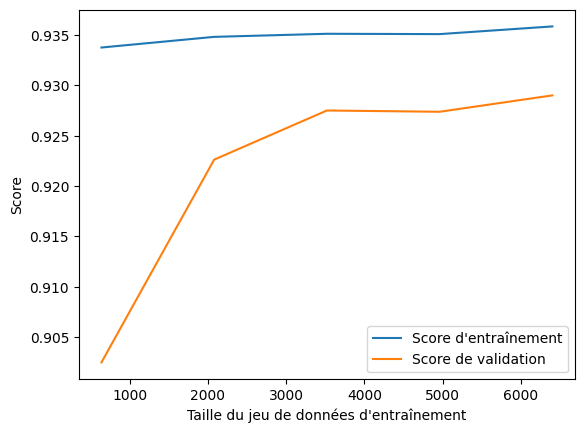

In [54]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt

train_sizes, train_scores, validation_scores = learning_curve(xgb_pipe_opti, X_train, y_train, cv=5)

plt.plot(train_sizes, train_scores.mean(axis=1), label='Score d\'entraînement')
plt.plot(train_sizes, validation_scores.mean(axis=1), label='Score de validation')
plt.xlabel('Taille du jeu de données d\'entraînement')
plt.ylabel('Score')
plt.legend()
plt.show()


De cela on a l'impression que le score d'entrainement , ne peut déjà plus être améliorer , mais le validation score peut encore être améliorer , avec plus de donnée cela atteindra sans doute son plateau 

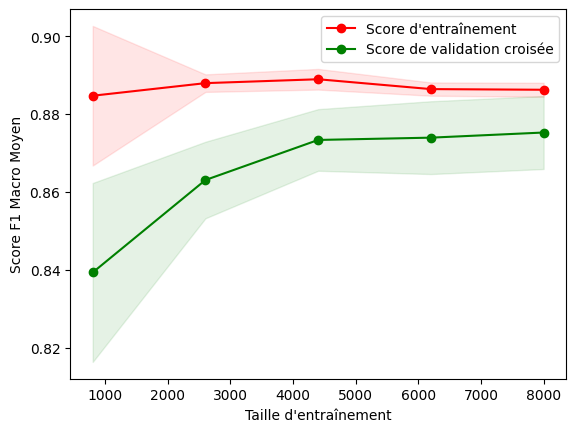

In [57]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

# Votre modèle optimisé


train_sizes, train_scores, test_scores = learning_curve(xgb_pipe_opti, X, y, cv=5, scoring='f1_macro', n_jobs=-1)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)

test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")

plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Score d'entraînement")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Score de validation croisée")

plt.xlabel("Taille d'entraînement")
plt.ylabel("Score F1 Macro Moyen")
plt.legend(loc="best")
plt.show()


même la on observe que l'on atteint un plateau ( peu étonnant vu le peu de variable on utilise )